In this work, I calculated the expected value of a car, depending on its parameters. I used Linear or other sifisticated Refressors, such as LGBMRegressor, CatBoostRegressor, RandomForestRegressor, LinearRegression, and more. Finaly I compared the models I got and checked them on a test database, according o some qualities parameters.

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# 1. Data preparation
## Libraries

In [62]:
import sklearn
import joblib
import pandas as pd
import numpy as np
from joblib import dump
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from catboost import CatBoostClassifier,CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Reading and looking the data

In [63]:
df = pd.read_csv('/datasets/car_data.csv')
display(df.head())
df.info()
df.describe()
print("Number of duplicated rows:",df.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
Number of duplicated rows: 262


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


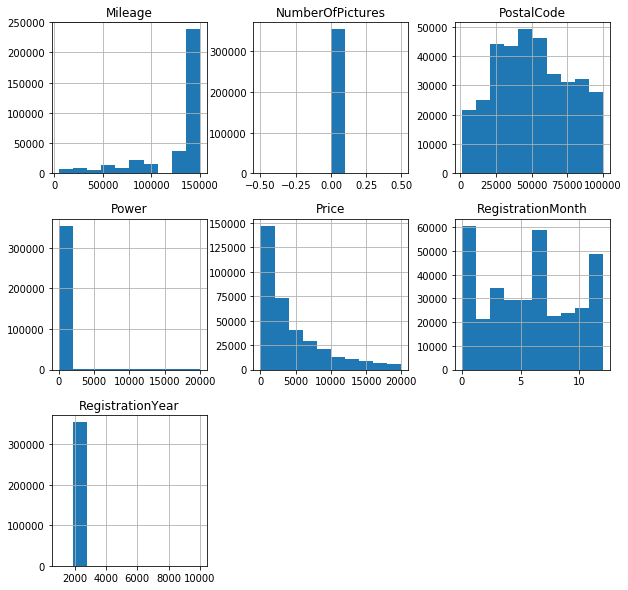

In [64]:
def print_graphs(df):
    df = df
    temp_raw_data=df.copy()
    fig = plt.figure(figsize = (10,10))
    ax = fig.gca()
    temp_raw_data.hist(ax = ax)
    fig = ax.get_figure()

print_graphs(df)


In [65]:
#checking rare or important values
print(df['Price'].value_counts())
print(df['NotRepaired'].value_counts())
print(df['Power'].value_counts())
print(df['RegistrationMonth'].value_counts())
print(df['Brand'].value_counts())
print(df['RegistrationYear'].unique())

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64
no     247161
yes     36054
Name: NotRepaired, dtype: int64
0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
16311        1
1360         1
1968         1
6226         1
6006         1
Name: Power, Length: 712, dtype: int64
0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64
volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
n

In [66]:
#checking object uniqu values
print(df['VehicleType'].unique())
print(df['Gearbox'].unique())
print(df['Model'].unique())
print(df['FuelType'].unique())
print(df['NotRepaired'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

### First Conclusion
1. We have Nan variables at: VehicleType, Model, FuelType, NotRepaired. The data is big enough an we can hadle without them.
2. Date, DateCreated and LastSeen are as type object instead of date.
3. Number of pictures is all-column of zeros.
4. Postal code seems not relevant, only if it is separated by rigions.
5. Power should not be 0. Only 10% of the observation had 0 power. We can't drop it, but fill with average or ffill.
6. Registration month may have 0, of unknown information. We will make the nan and drop them.
7. Registration year should be between 1920 and 2020.
8. The model has lots of unique values, and it will affect our time running model. We will drop it.

## Preprocess of the data

In [67]:
#drop
df = df.drop(columns=['PostalCode','NumberOfPictures','Model'], axis=1)
# removing duplicated rows
df.drop_duplicates(keep = False, inplace = True) 
#had a problem with one of the observarions, which had not filled up
df['VehicleType'] = df['VehicleType'].fillna('small')  
df['NotRepaired'] = df['NotRepaired'].fillna('no')
#replace 0 with Nans in registration month and price since it makes
df['RegistrationMonth'].replace(0, np.nan, inplace=True)
#dates
df['DateCrawled']= pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated']= pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen']= pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')
# drop nan
df.dropna(inplace=True)

display(df.describe())
display(df.head())
df.info()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,289426.000000,289426.000000,289426.000000,289426.000000,289426.000000
mean,4878.846683,2003.172037,117.512003,128013.948298,6.382955
std,4641.188875,19.093342,171.417081,36916.159639,3.349253
min,0.000000,1000.000000,0.000000,5000.000000,1.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,4.000000
50%,3200.000000,2003.000000,109.000000,150000.000000,6.000000
75%,7000.000000,2007.000000,147.000000,150000.000000,9.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,125000,5.0,gasoline,audi,yes,2016-03-24,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,125000,8.0,gasoline,jeep,no,2016-03-14,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,150000,6.0,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,90000,7.0,gasoline,skoda,no,2016-03-31,2016-04-06 10:17:00
5,2016-04-04 17:36:00,650,sedan,1995,manual,102,150000,10.0,petrol,bmw,yes,2016-04-04,2016-04-06 19:17:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 289426 entries, 1 to 354368
Data columns (total 13 columns):
DateCrawled          289426 non-null datetime64[ns]
Price                289426 non-null int64
VehicleType          289426 non-null object
RegistrationYear     289426 non-null int64
Gearbox              289426 non-null object
Power                289426 non-null int64
Mileage              289426 non-null int64
RegistrationMonth    289426 non-null float64
FuelType             289426 non-null object
Brand                289426 non-null object
NotRepaired          289426 non-null object
DateCreated          289426 non-null datetime64[ns]
LastSeen             289426 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(4), object(5)
memory usage: 30.9+ MB


In [68]:
# Power without the zeros, and extreme numbers
aa = df[df.Power != 0]
aa2 = aa['Power']
power_mean = (int(aa2.mean()))

def Power_no_zero(row):
    pw = row['Power']
    if pw == 0 :
        return power_mean
    elif pw > 200:
        return 200
    return pw

df['Power'] = df.apply(Power_no_zero, axis=1)

In [69]:
# RegistrationYear between 1920-2020. Most values are 2000, thus, we gonna make all cars non identify over 2020 to 2000.

def correct_year(row):
    ye = row['RegistrationYear']
    if ye <= 1920 :
        return 1920
    elif ye > 2020:
        return 2000
    return ye

df['RegistrationYear'] = df.apply(correct_year, axis=1)

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,289426.000000,289426.000000,289426.000000,289426.000000,289426.000000
mean,4878.846683,2003.106773,118.444587,128013.948298,6.382955
std,4641.188875,6.745838,43.003382,36916.159639,3.349253
min,0.000000,1920.000000,1.000000,5000.000000,1.000000
25%,1350.000000,1999.000000,82.000000,125000.000000,4.000000
50%,3200.000000,2003.000000,116.000000,150000.000000,6.000000
75%,7000.000000,2007.000000,147.000000,150000.000000,9.000000
max,20000.000000,2019.000000,200.000000,150000.000000,12.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,125000,5.0,gasoline,audi,yes,2016-03-24,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,125000,8.0,gasoline,jeep,no,2016-03-14,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,150000,6.0,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,90000,7.0,gasoline,skoda,no,2016-03-31,2016-04-06 10:17:00
5,2016-04-04 17:36:00,650,sedan,1995,manual,102,150000,10.0,petrol,bmw,yes,2016-04-04,2016-04-06 19:17:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 289426 entries, 1 to 354368
Data columns (total 13 columns):
DateCrawled          289426 non-null datetime64[ns]
Price                289426 non-null int64
VehicleType          289426 non-null object
RegistrationYear     289426 non-null int64
Gearbox              289426 non-null object
Power                289426 non-null int64
Mileage              289426 non-null int64
RegistrationMonth    289426 non-null float64
FuelType             289426 non-null object
Brand                289426 non-null object
NotRepaired          289426 non-null object
DateCreated          289426 non-null datetime64[ns]
LastSeen             289426 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(4), object(5)
memory usage: 30.9+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


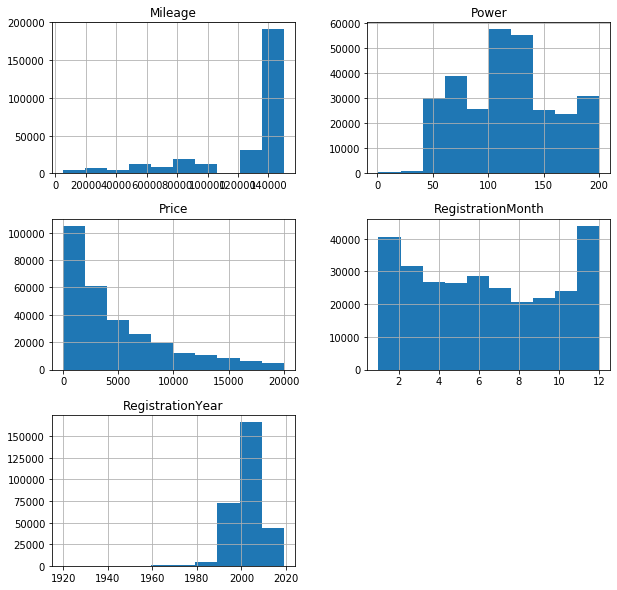

In [70]:
display(df.describe())
display(df.head())
df.info()
print_graphs(df)

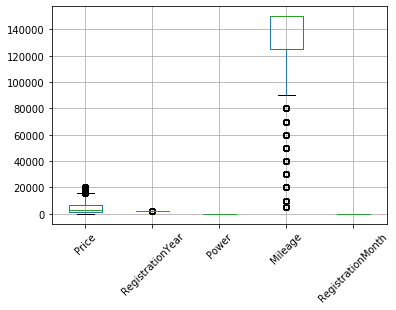

In [71]:
df.boxplot(rot=45)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe383892b90>,
      dtype=object)

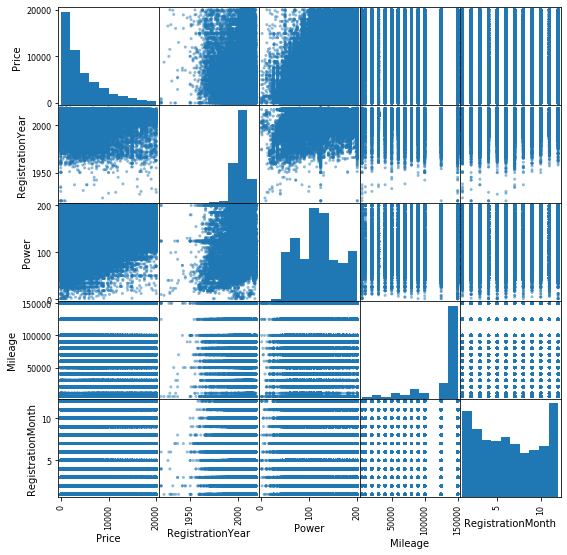

In [29]:
for_plot = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen','VehicleType',
                            'Gearbox','Model','FuelType','Brand','NotRepaired'], axis=1)
pd.plotting.scatter_matrix(for_plot, figsize=(9, 9))

In [72]:
#checking if years are relevant on the dates columns
print('--------------- DateCrawled ---------------')
df['year_of_crawled'] = pd.DatetimeIndex(df['DateCrawled']).year
df['year_of_crawled'] = df['year_of_crawled'].astype('Int32')
print(df['year_of_crawled'].describe())

print('--------------- DateCreated ---------------')
df['year_of_created'] = pd.DatetimeIndex(df['DateCreated']).year
df['year_of_created'] = df['year_of_created'].astype('Int32')
print(df['year_of_created'].describe())

print('--------------- LastSeen ---------------')
df['year_of_lastSeen'] = pd.DatetimeIndex(df['LastSeen']).year
df['year_of_lastSeen'] = df['year_of_lastSeen'].astype('Int32')
print(df['year_of_lastSeen'].describe())

--------------- DateCrawled ---------------
count    289426.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: year_of_crawled, dtype: float64
--------------- DateCreated ---------------
count    289426.000000
mean       2015.999921
std           0.008914
min        2015.000000
25%        2016.000000
50%        2016.000000
75%        2016.000000
max        2016.000000
Name: year_of_created, dtype: float64
--------------- LastSeen ---------------
count    289426.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: year_of_lastSeen, dtype: float64


In [73]:
# years seems irrelevant, we will drop them
df = df.drop(columns=['year_of_crawled', 'year_of_created', 'year_of_lastSeen'])

### Second Conclusion

Dates seem not relevant, all have same year for the date it entered or viewed on the database, and month is not a parameter that is relevant for selling cars.

'Mileage' feature has a left-tale, while the target, 'Price', is a right-taled parameter. This can cofuse very much the model trained. 

'Power' and 'RegistrationYear' are quite normalized.

Objetc-type columns should turn to dummies.

We found no special direct correlation between features and the target.

# 2. Model training

In [74]:
df_dummies = pd.get_dummies(df, drop_first=True)

### Preparing the data

In [75]:
target = df_dummies['Price']
features = df_dummies.drop(columns=['Price','DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
features_1, features_test, target_1, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

features_1 = features_1.reset_index()
features_test = features_test.reset_index()
target_1 = target_1.reset_index()
target_test = target_test.reset_index()

print('Size of features to train:', features_train.shape)
print('Size of features to validate:', features_valid.shape)
print('Size of features to test:', features_test.shape)

Size of features to train: (162801, 58)
Size of features to validate: (54268, 58)
Size of features to test: (72357, 59)


### Fast check for models
#### Decision Tree Regressor

In [76]:
%%time
model = DecisionTreeRegressor()
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 2275.3628910463444
mean: 4876.472306096297
CPU times: user 2.09 s, sys: 43.7 ms, total: 2.14 s
Wall time: 2.14 s


#### Random Forest Regressor

In [77]:
%%time
model = RandomForestRegressor(n_estimators=10, random_state=12345)
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 1885.6187378145685
mean: 4870.806909582806
CPU times: user 13.6 s, sys: 71.1 ms, total: 13.6 s
Wall time: 13.6 s


#### LGBM Regressor

In [78]:
%%time
model = LGBMRegressor()
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 1862.356020347257
mean: 4858.994141511393
CPU times: user 2.9 s, sys: 68 ms, total: 2.97 s
Wall time: 2.97 s


#### Cat Boost Regressor

In [94]:
%%time
model = CatBoostRegressor(loss_function="RMSE", iterations=20)
model.fit(features_train, target_train, verbose=False)
predicted_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 3342.9592246716466
mean: 4873.479902991756
CPU times: user 3.16 s, sys: 297 ms, total: 3.46 s
Wall time: 7.12 s


#### XGB Regressor

In [80]:
%%time
model = XGBRegressor()
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 2070.8184356426427
mean: 4859.4146
CPU times: user 33.7 s, sys: 285 ms, total: 34 s
Wall time: 34.5 s


### First impression
Both LGBMRegressor and DecisionTreeRegressor where the fastest models, then CatBoostRegressor, RandomForestRegressor and finally XGBRegressor. Since its time, that is 1000% slower that LGBMRegressor, we would not continue to check them.

All models have prety much the same average of target values, but LGBMRegressor and RandomForestRegressor models had much better RMSE value.

In [91]:
def cross_val_score_decisionTree_regressor (features1, target1, depth):
    scores = []
    sample_size = int(len(features1)/3)
    for i in range(0, 3, 1):
        valid_indexes = features1.iloc[i:i+sample_size].index
        train_indexes = features1[~(features1.index.isin(valid_indexes))].index
        features_train = features1.iloc[train_indexes]
        features_valid = features1.iloc[valid_indexes]
        target_train = target1.iloc[train_indexes]
        target_valid = target1.iloc[valid_indexes]
        
        model = DecisionTreeRegressor(max_depth=depth,random_state=12345)
        model = model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predicted_valid)**0.5
        scores.append(rmse)
    return scores

In [92]:
%%time
for depth in range(7,15):
    scores = cross_val_score_decisionTree_regressor (features_1, target_1,depth)
    final_score = pd.Series(scores).mean()  
    print("Depth =", depth, ": ", end='')
    print('DecisionTreeRegressor Average model RMSE score:', final_score)
    print('----------------------------------------------')

Depth = 7 : DecisionTreeRegressor Average model RMSE score: 2870.733569985164
----------------------------------------------
Depth = 8 : DecisionTreeRegressor Average model RMSE score: 2581.653234290824
----------------------------------------------
Depth = 9 : DecisionTreeRegressor Average model RMSE score: 2369.3295638361797
----------------------------------------------
Depth = 10 : DecisionTreeRegressor Average model RMSE score: 2209.682420516879
----------------------------------------------
Depth = 11 : DecisionTreeRegressor Average model RMSE score: 2102.0527095631296
----------------------------------------------
Depth = 12 : DecisionTreeRegressor Average model RMSE score: 2074.4295510480038
----------------------------------------------
Depth = 13 : DecisionTreeRegressor Average model RMSE score: 2087.967694268355
----------------------------------------------
Depth = 14 : DecisionTreeRegressor Average model RMSE score: 2146.814871005447
---------------------------------------

In [107]:
def cross_val_randomForest_regressor (features1, target1, estimators):
    scores = []
    sample_size = int(len(features1)/3)
    for i in range(0, 3, 1):
        valid_indexes = features1.iloc[i:i+sample_size].index
        train_indexes = features1[~(features1.index.isin(valid_indexes))].index
        features_train = features1.iloc[train_indexes]
        features_valid = features1.iloc[valid_indexes]
        target_train = target1.iloc[train_indexes]
        target_valid = target1.iloc[valid_indexes]
        
        model = RandomForestRegressor(n_estimators=estimators, random_state=12345)
        model = model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predicted_valid)**0.5
        scores.append(rmse)
    return scores

In [101]:
%%time
for estimators in range(10,81,10):
    scores = cross_val_randomForest_regressor (features_1, target_1, estimators)
    final_score = pd.Series(scores).mean()
    print("Estimators =", estimators, ": ", end='')
    print('RandomForestRegressor Average model RMSE score:', final_score)
    print('----------------------------------------------')

Estimators = 10 : RandomForestRegressor Average model RMSE score: 1743.6230925263326
----------------------------------------------
Estimators = 20 : RandomForestRegressor Average model RMSE score: 1698.0317582518448
----------------------------------------------
Estimators = 30 : RandomForestRegressor Average model RMSE score: 1680.9292748571117
----------------------------------------------
Estimators = 40 : RandomForestRegressor Average model RMSE score: 1674.311269786661
----------------------------------------------
Estimators = 50 : RandomForestRegressor Average model RMSE score: 1669.3485432857826
----------------------------------------------
Estimators = 60 : RandomForestRegressor Average model RMSE score: 1666.5788781054962
----------------------------------------------
Estimators = 70 : RandomForestRegressor Average model RMSE score: 1664.1628737059764
----------------------------------------------
Estimators = 80 : RandomForestRegressor Average model RMSE score: 1661.877087

In [87]:
def LGBM_regressor_func (features1, target1, estimators):
    model = LGBMRegressor(n_estimators=estimators, random_state=12345)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    mean = pd.Series(predicted_valid).mean()
    return rmse, mean

In [102]:
%%time
for estimators in range(30,131,10):
    rmse,mean = LGBM_regressor_func (features_1, target_1,estimators)
    print("Estimators =", estimators, ": ", end='')
    print('LGBMRegressor Average model RMSE score:', rmse)
    print("mean:", mean)
    print('----------------------------------------------')

Estimators = 30 : LGBMRegressor Average model RMSE score: 2050.836728441111
mean: 4860.436494096475
----------------------------------------------
Estimators = 40 : LGBMRegressor Average model RMSE score: 1974.5365997261556
mean: 4859.142405207846
----------------------------------------------
Estimators = 50 : LGBMRegressor Average model RMSE score: 1934.6896071628066
mean: 4859.242849111984
----------------------------------------------
Estimators = 60 : LGBMRegressor Average model RMSE score: 1909.8847462562082
mean: 4858.217163073886
----------------------------------------------
Estimators = 70 : LGBMRegressor Average model RMSE score: 1892.9102869573794
mean: 4858.248044465211
----------------------------------------------
Estimators = 80 : LGBMRegressor Average model RMSE score: 1879.2953800458185
mean: 4858.46809256115
----------------------------------------------
Estimators = 90 : LGBMRegressor Average model RMSE score: 1870.4146838815366
mean: 4859.0550375468965
------------

Some models took lot of time to fit. Thus, cross-validation and parameter tunning were almost impossible for those models but LGBMRegressor and DecisionTreeRegressor. RandomForestRegressor tunning show us that for more than 30 estimators we get the best value for rmse, but took it too much time.

The default parameters for LGBMRegressor had the best result for it, and its running was much quicker than the RandomForestRegressor.

We will finally check between LGBMRegressor default parameters, RandomForestRegressor with 30 estimators and DecisionTreeRegressor depth of 12.

# 3. Model analysis

Some models took lot of time to fit. Thus, cross-validation and parameter tunning were almost impossible for those models but LGBMRegressor and DecisionTreeRegressor. RandomForestRegressor tunning show us that for more than 30 estimators we get the best value for rmse, but took it too much time.

The default parameters for LGBMRegressor had the best result for it, and its running was much quicker than the RandomForestRegressor.


In [111]:
target = df_dummies['Price']
features = df_dummies.drop(columns=['Price','DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
features_1, features_test, target_1, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [112]:
%%time
model = DecisionTreeRegressor(max_depth=12,random_state=12345)
model.fit(features_1,target_1)
predicted_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test)**0.5
print("Final Decision Tree Regressor model rmse:", rmse)
print("Final Decision Tree Regressor model mean:", pd.Series(predicted_test).mean())

Final Decision Tree Regressor model rmse: 2054.7986423851175
Final Decision Tree Regressor model mean: 4885.452260493594
CPU times: user 1.4 s, sys: 48.1 ms, total: 1.44 s
Wall time: 1.45 s


In [113]:
%%time
model = RandomForestRegressor(n_estimators=30, random_state=12345)
model.fit(features_1,target_1)
predicted_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test)**0.5
print("Final Random Forest Regressor model rmse:", rmse)
print("Final Random Forest Regressor model mean:", pd.Series(predicted_test).mean())

Final Random Forest Regressor model rmse: 1819.5745529639519
Final Random Forest Regressor model mean: 4906.81866205276
CPU times: user 49.6 s, sys: 444 ms, total: 50.1 s
Wall time: 50.2 s


In [114]:
%%time
model = LGBMRegressor()
model.fit(features_1,target_1)
predicted_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test)**0.5
print("Final LGBM Regressor model rmse:", rmse)
print("Final LGBM Regressor model mean:", pd.Series(predicted_test).mean())

Final LGBM Regressor model rmse: 1867.534779164259
Final LGBM Regressor model mean: 4886.649369598528
CPU times: user 3.53 s, sys: 132 ms, total: 3.66 s
Wall time: 3.68 s


### Best Model
As usual, we want to minimize our evaluation parameter. In this case, RMSE had the lowest average score (after cross-validation) for the RandomForestRegressor model, but was very slow when calculating the model. In contrast, LGBMRegressor model was fast on calculating and fitting the model and have also good results, with an RMSE value under 1900.

The final score is near to the train score but higher, showing us that the validation step was a bit overfitted.
Including time as an important parameter, LGBMRegressor is the best model for this task.

### Project Evaluation
On this project we deal with nan values, impossible values, non important colums, types of columns not fittable for the model and other problems.
When looking for a model, two types of training we tried, tunning for hyperparameters. The first is running the model normaly, and the second is cross-validation, used only for models who run fast.
Both LGBMRegressor and DecisionTreeRegressor, where the models who run slow, but much faster than the other two, CatBoostRegressor and RandomForestRegressor. LogisticRegression model did not even finished.
We found that almost all tthe models braught us to the same mean of Price, \$4420, near to the real mean of price. But, since the Price values are differ from each other, with a lon right-tale, making it that the median is much lower to the mean value, the models had difficult to predict the correct target value, thus the RMSE was very high.

## Draft

In [ ]:
# model = LogisticRegression(random_state=12345, max_iter=20)
# model.fit(features_train,target_train)
# predicted_valid = model.predict(features_valid)
# rmse = mean_squared_error(target_valid, predicted_valid)**0.5
# print("rmse:", rmse)
# print("mean:", pd.Series(predicted_valid).mean())

In [78]:
# def cross_val_score_linear_regression (features, target):
#     scores = []
#     sample_size = int(len(features)/3)
#     for i in range(0, len(features), sample_size):
#         valid_indexes = features.iloc[i:i+sample_size].index
#         train_indexes = features[~(features.index.isin(valid_indexes))].index

#         features_train = features.iloc[train_indexes]
#         features_valid = features.iloc[valid_indexes]
#         target_train = target.iloc[train_indexes]
#         target_valid = target.iloc[valid_indexes].reset_index()
        
#         model = LinearRegression()
#         model = model.fit(features_train, target_train)
#         predicted_valid = model.predict(features_valid)
#         rmse = mean_squared_error(target_valid, predicted_valid)**0.5
#         scores.append(rmse)
#     return scores

In [89]:
# %%time
# for itera in range(10,81,10):
#     model = CatBoostRegressor(loss_function="RMSE", iterations=itera)
#     model.fit(features_train, target_train, verbose=False)
#     predicted_valid = model.predict(features_valid)
#     rmse = mean_squared_error(target_valid, predicted_valid)**0.5
#     print("Iterations =", itera, ": ", end='')
#     print('RandomForestRegressor Average model RMSE score:', rmse)
#     print("mean:", pd.Series(predicted_valid).mean())
#     print('----------------------------------------------')

Iterations = 10 : RandomForestRegressor Average model RMSE score: 3860.412048617005
mean: 4877.318143825994
----------------------------------------------
Iterations = 20 : RandomForestRegressor Average model RMSE score: 3342.9592246716466
mean: 4873.479902991756
----------------------------------------------
Iterations = 30 : RandomForestRegressor Average model RMSE score: 2990.2914818892395
mean: 4871.3416647780705
----------------------------------------------
Iterations = 40 : RandomForestRegressor Average model RMSE score: 2752.97661236894
mean: 4869.486613321317
----------------------------------------------
Iterations = 50 : RandomForestRegressor Average model RMSE score: 2587.9035718583473
mean: 4868.634127339074
----------------------------------------------
Iterations = 60 : RandomForestRegressor Average model RMSE score: 2474.1543873432333
mean: 4867.876574074577
----------------------------------------------
Iterations = 70 : RandomForestRegressor Average model RMSE score: 

In [82]:
# scores = cross_val_score_linear_regression (features_1, target)
# final_score = pd.Series(scores).mean()  
# print('LinearRegression Average model RMSE score:', final_score)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
# def get_precent_of_na_df(df,num):
#     df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
#     df_nulls['Percent of Nulls %'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
#     df_nulls = df_nulls.sort_values("Percent of Nulls %",ascending=False)
#     return df_nulls

# def Explore(df):
#     df = df
#     print(df.head())
#     print("Number of duplicated rows",df.duplicated().sum())
#     print("Data shape",df.shape)
#     print('Columns with nulls:')
#     display(get_precent_of_na_df(df,4))
#     display(df.info())
#     display(df.describe())
#     print("Number of duplicated rows")
#     display(df.duplicated().sum())
#     temp_raw_data=df.copy()
#     fig = plt.figure(figsize = (7,10))
#     ax = fig.gca()
#     temp_raw_data.hist(ax = ax)
#     fig = ax.get_figure()

In [93]:
# def RandomForestRegressor_func (features1, target1, estimators):
#     model = RandomForestRegressor(n_estimators=estimators, random_state=12345)
#     model.fit(features_train,target_train)
#     predicted_valid = model.predict(features_valid)
#     rmse = mean_squared_error(target_valid, predicted_valid)**0.5
#     mean = pd.Series(predicted_valid).mean()
#     return rmse, mean      

In [86]:
# %%time
# for estimators in range(10,81,10):
#     rmse, mean = RandomForestRegressor_func (features_1, target_1, estimators)
#     print("Estimators =", estimators, ": ", end='')
#     print('RandomForestRegressor Average model RMSE score:', rmse)
#     print("mean:", mean)
#     print('----------------------------------------------')

Estimators = 10 : RandomForestRegressor Average model RMSE score: 1885.6187378145685
mean: 4870.806909582806
----------------------------------------------
Estimators = 20 : RandomForestRegressor Average model RMSE score: 1852.8563716138628
mean: 4868.455464326933
----------------------------------------------
Estimators = 30 : RandomForestRegressor Average model RMSE score: 1841.5439367545982
mean: 4868.9486200117235
----------------------------------------------
Estimators = 40 : RandomForestRegressor Average model RMSE score: 1835.2940521274415
mean: 4869.369286682485
----------------------------------------------
Estimators = 50 : RandomForestRegressor Average model RMSE score: 1830.7695855568984
mean: 4869.877799649988
----------------------------------------------
Estimators = 60 : RandomForestRegressor Average model RMSE score: 1828.2605875725803
mean: 4869.574040639633
----------------------------------------------
Estimators = 70 : RandomForestRegressor Average model RMSE scor